In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV,Lasso,LassoCV
from sklearn import metrics
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols,wls
from matplotlib import pyplot as plt
import shap

In [2]:
raw_data=np.load('new_feature_matrix.npy')

In [3]:
raw_data.shape

(90, 172, 5)

# Classified by zipcode

In [4]:
# ignore time and zipcode
columns_types = {
    'placekey': int,
    'Median_Household_Income': float,
    'Total_Population': int,
    'case_rate': float,
    'raw_visit_counts': int
}
data_zipcode={}
for i in range(raw_data.shape[1]):
    data_zipcode[i]=pd.DataFrame(raw_data[:,i,:],columns=['placekey', 'Median_Household_Income', 'Total_Population', 'case_rate', 'raw_visit_counts']).astype(columns_types)
    data_zipcode[i][['placekey', 'Median_Household_Income', 'Total_Population', 'case_rate']]=data_zipcode[i][['placekey', 'Median_Household_Income', 'Total_Population', 'case_rate']].shift()
#     data_zipcode[i]['raw_visit_counts_2']=data_zipcode[i]['raw_visit_counts'].shift()
#     data_zipcode[i]=data_zipcode[i].dropna()

In [5]:
data_zipcode[0]

,placekey,Median_Household_Income,Total_Population,case_rate,raw_visit_counts
0,NaN,NaN,NaN,NaN,37481
1,1079.0,24497.0,114473.0,7.24,37765
2,1051.0,24497.0,114473.0,14.49,41844
3,1056.0,24497.0,114473.0,14.49,38903
4,1075.0,24497.0,114473.0,7.24,40858
...,...,...,...,...,...
85,1163.0,24497.0,114473.0,181.07,56223
86,1150.0,24497.0,114473.0,278.85,59327
87,1243.0,24497.0,114473.0,289.72,75769
88,1393.0,24497.0,114473.0,380.25,89845


In [6]:
# 说明Median_Household_Income和Total_Population在同一个zipcode下一摸一样
# data['log_y']=np.log(data['raw_visit_counts'])
d={key:0 for key in ['Median_Household_Income', 'Total_Population', 'case_rate']}
for j in data_zipcode.keys():
    for i in ['Median_Household_Income', 'Total_Population', 'case_rate']:
        if len(data_zipcode[j][i].unique())==1:
            d[i]+=1
print(d)
# With the same zipcode, 'Median_Household_Income' and 'Total_Population' are same.

{'Median_Household_Income': 0, 'Total_Population': 0, 'case_rate': 0}


## Lag data ACF

In [7]:
lag_data={}
for i in data_zipcode.keys():
    lag_data[i]=pd.DataFrame(index=data_zipcode[i].index)
    for j in range(10):
        lag_data[i][f'lag_{j}']=data_zipcode[i]['raw_visit_counts'].shift(j)

In [8]:
fig, axs = plt.subplots(16, 11, figsize=(100, 80), gridspec_kw={'hspace': 0.3, 'wspace': 0.2})
plt.subplots_adjust(top=0.95)
plt.suptitle("Autocorrelation", fontsize=50, fontweight='bold')
for i in range(len(lag_data.keys())):
    acvf=lag_data[i].cov().iloc[0,:]
    acf=acvf/lag_data[i].cov().iloc[0,0]
    axs[i//11,i%11].plot(acf,marker='s')
    axs[i//11,i%11].set_title(i)
for ax_row in axs:
    for ax in ax_row:
        if not ax.has_data():
            ax.axis('off')
plt.show()

### 结论：
# 不同zipcode差距较大：1.下降模式不同 2.有的能下降到0甚至负数，有的还维持在0.5

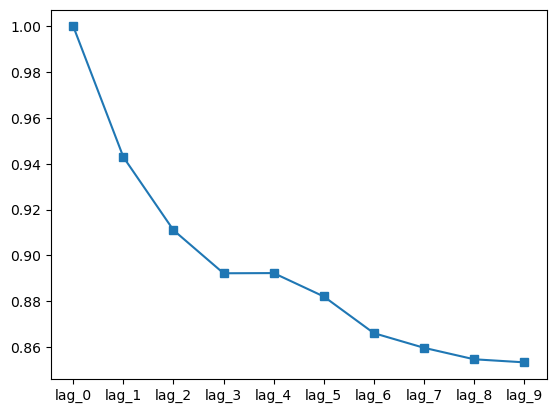

In [9]:
lag_data_all=pd.DataFrame()
for i in lag_data.keys():
    lag_data_all=pd.concat([lag_data_all,lag_data[i]])

acvf=lag_data_all.cov().iloc[0,:]
acf=acvf/lag_data_all.cov().iloc[0,0]
plt.plot(acf,marker='s')
plt.show()

### 全体的自相关系数下降很慢的原因：
# n = 1000
# x1 = np.random.rand(n)
# y1 = 0.5 * x1 + np.random.rand(n)
# df1=pd.DataFrame({'x':x1,'y':y1})
# df1.corr()

# x2 = -5*x1
# y2 = 0.1 * x2 + np.random.rand(n)
# df2=pd.DataFrame({'x':x2,'y':y2})
# df2.corr()

# df3=pd.concat([df1,df2])
# df3.corr()

# # 果然有些zipcode之间的相关系数是负的
# temp=pd.DataFrame()
# for i in lag_data.keys():
#     if i==0:
#         continue
#     temp=pd.concat([lag_data[i-1]['lag_0'],lag_data[i]['lag_0']],axis=1)
#     if(temp.corr().iloc[0,1]<0):
#         print(i)

## Model

In [10]:
new_data_all=pd.DataFrame()
for i in lag_data.keys():
    temp=pd.concat([data_zipcode[i][['Median_Household_Income', 'Total_Population', 'case_rate']],lag_data[i]],axis=1)
    new_data_all=pd.concat([new_data_all,temp])
new_data_all.dropna(inplace=True)
new_data_all # lag_0是y

,Median_Household_Income,Total_Population,case_rate,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9
9,24497.0,114473.0,36.21,45307,42831.0,43330.0,40776.0,39501.0,40858.0,38903.0,41844.0,37765.0,37481.0
10,24497.0,114473.0,39.84,41127,45307.0,42831.0,43330.0,40776.0,39501.0,40858.0,38903.0,41844.0,37765.0
11,24497.0,114473.0,32.59,42705,41127.0,45307.0,42831.0,43330.0,40776.0,39501.0,40858.0,38903.0,41844.0
12,24497.0,114473.0,50.70,42740,42705.0,41127.0,45307.0,42831.0,43330.0,40776.0,39501.0,40858.0,38903.0
13,24497.0,114473.0,36.21,45330,42740.0,42705.0,41127.0,45307.0,42831.0,43330.0,40776.0,39501.0,40858.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,19826.0,101618.0,52.94,658,700.0,586.0,928.0,733.0,342.0,359.0,316.0,323.0,430.0
86,19826.0,101618.0,110.69,484,658.0,700.0,586.0,928.0,733.0,342.0,359.0,316.0,323.0
87,19826.0,101618.0,101.06,694,484.0,658.0,700.0,586.0,928.0,733.0,342.0,359.0,316.0
88,19826.0,101618.0,168.44,661,694.0,484.0,658.0,700.0,586.0,928.0,733.0,342.0,359.0


In [11]:
def cata_population(series_population): # 分类，high low median population
    lower=series_population.quantile(0.3)
    upper=series_population.quantile(0.7)
    def cata_fun(x,upper,lower):
        if x<=lower:
            return 'Low'
        if x>upper:
            return 'High'
        return 'Median'
    series_population=series_population.apply(cata_fun,args=(upper,lower))
    return series_population
new_data_all['Total_Population']=cata_population(new_data_all['Total_Population'])

## Linear Regression with one model

### Togrther

In [12]:
new_data_all['Total_Population']=new_data_all['Total_Population'].astype('category')
new_data_all=new_data_all.drop(columns=['Median_Household_Income'])

In [13]:
# x_names=''.join([f'lag_{i}+' for i in range(1,10)]) # 'lag_1+lag_2+lag_3+lag_4+lag_5+lag_6+lag_7+lag_8+lag_9+'
# elm = ols('lag_0 ~ '+x_names+'Total_Population + case_rate', data=new_data_all).fit()
# elm.summary()#.tables[1]
# 为了底下shap分析，用sklearn的线性回归，结果和上面一致
new_data_all_onehot=pd.get_dummies(new_data_all, columns=['Total_Population'])
new_data_all_onehot=new_data_all_onehot.reset_index(drop=True)
lm = LinearRegression()
x=new_data_all_onehot.loc[:,~new_data_all_onehot.columns.isin(['lag_0'])]
lm.fit(x, new_data_all_onehot['lag_0'])
print('R^2:',lm.score(x, new_data_all_onehot['lag_0']))
pd.concat([pd.Series(lm.coef_,index=x.columns.tolist()),pd.Series(lm.intercept_,index=['intercept'])])

R^2: 0.9261221164178182


case_rate                   -0.305165
lag_1                        0.624658
lag_2                        0.022284
lag_3                        0.042739
lag_4                        0.146761
lag_5                        0.107412
lag_6                       -0.049141
lag_7                        0.042154
lag_8                       -0.007580
lag_9                        0.063606
Total_Population_High      117.893445
Total_Population_Low       -48.285876
Total_Population_Median    -69.607569
intercept                  187.767366
dtype: float64

In [14]:
explainer = shap.Explainer(lm, x)
shap_values = explainer.shap_values(x)
# shap.summary_plot(shap_values, x)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], x.iloc[0,:]) 

### zipcode specify

In [15]:
one_zipcode=data_zipcode[0]
temp=pd.DataFrame(index=one_zipcode.index)
for j in range(10):
    temp[f'lag_{j}']=one_zipcode['raw_visit_counts'].shift(j)
temp
one_zipcode
one_zipcode=pd.concat([one_zipcode[['Median_Household_Income', 'Total_Population', 'case_rate']],temp],axis=1)
one_zipcode=one_zipcode.dropna()
# one_zipcode['Total_Population']=cata_population(one_zipcode['Total_Population'])
# one_zipcode['Total_Population']=one_zipcode['Total_Population'].astype('category')
one_zipcode=one_zipcode.drop(columns=['Median_Household_Income','Total_Population'])

In [17]:
# one_zipcode_onehot=pd.get_dummies(one_zipcode, columns=['Total_Population'])
one_zipcode_onehot=one_zipcode
one_zipcode_onehot=one_zipcode_onehot.reset_index(drop=True)
lm = LinearRegression()
x=one_zipcode_onehot.loc[:,~one_zipcode_onehot.columns.isin(['lag_0'])]
lm.fit(x, one_zipcode_onehot['lag_0'])
print('R^2:',lm.score(x, one_zipcode_onehot['lag_0']))
pd.concat([pd.Series(lm.coef_,index=x.columns.tolist()),pd.Series(lm.intercept_,index=['intercept'])])

R^2: 0.7927054127661344


case_rate      -4.495761
lag_1           0.691312
lag_2          -0.034177
lag_3           0.107830
lag_4           0.095511
lag_5           0.012897
lag_6           0.241682
lag_7          -0.087161
lag_8           0.060147
lag_9           0.050452
intercept   -3909.842481
dtype: float64

In [18]:
explainer = shap.Explainer(lm, x)
shap_values = explainer.shap_values(x)
# shap.summary_plot(shap_values, x)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], x.iloc[0,:]) 

## Xgboost with one model

In [27]:
# import xgboost as xgb
# import warnings
# warnings.filterwarnings("ignore")

# x=new_data_all_onehot.loc[:,~new_data_all_onehot.columns.isin(['lag_0'])]

# reg=xgb.XGBRegressor(n_estimators=50)
# reg.fit(x,new_data_all_onehot['lag_0'])

In [28]:
# explainer_xgb = shap.Explainer(reg, x.values)
# shap_values = explainer_xgb.shap_values(x)
# # shap.summary_plot(shap_values, x)
# shap.initjs()
# shap.force_plot(explainer_xgb.expected_value, shap_values[0,:], x.iloc[0,:])